# Dragging gestures: Analysis

In [18]:
import numpy as np
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os, shutil

# for linear regression summary
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import normal_ad

In [19]:
iodModelName = 'log(kappa+length)'
# iodModelName = 'kappa'
# iodModelName = 'length'
centralTendency = 'mean'
# centralTendency = 'median'

funcIoDs = {
    'kappa*length': json.load(open('index_of_difficulty-' + iodModelName +'.json')),
    'length': json.load(open('index_of_difficulty-' + 'length' +'.json')),
    'kappa': json.load(open('index_of_difficulty-' + 'kappa' +'.json')),
    'log(kappa+length)': json.load(open('index_of_difficulty-log(kappa+length).json'))
}

In [20]:
# prepare folders and erase all figures
# only remove folders which are going to be changed by executing this script

figuresFoldername = 'figures'
drawingTimeHistogramsFoldername = 'drawing_time_histograms'
linearRegressionFoldername = 'linear_regressions'
takeScreenshots = False

drawingTimeHistogramsFolderPath = figuresFoldername + "/" + drawingTimeHistogramsFoldername + "/"
linearRegressionsFolderPath = figuresFoldername + "/" + linearRegressionFoldername \
    + "/" + iodModelName \
    + "/" + centralTendency + "/"
participantDataFolderPath = figuresFoldername + "/participants/"

def saveFigure(figurename):
    figurename = figurename.replace(' ', '_').replace('\n', '')
    if(takeScreenshots is True):
        plt.savefig(figurename)

def resetFigureFolder(foldername):
    if(os.path.exists(foldername)):
        shutil.rmtree(foldername)
    os.makedirs(foldername)

if(takeScreenshots is True):
    foldersToBeChanged = [
        drawingTimeHistogramsFolderPath,
        linearRegressionsFolderPath,
        participantDataFolderPath
    ]
    
    for foldername in foldersToBeChanged:
        print(foldername)
        resetFigureFolder(foldername)    


In [21]:
df = pd.read_csv('logs.csv')

print("Columns:", df.columns)
# indices of important columns
prAgeInd = 1
deviceInd = 2
testModeInd = 3
funcIdInd = 5
funcDiffInd = 6
funcProjInd = 7
drawTimeInd = 8

test0data = df[df['Test mode'] == 0]
test1data = df[df['Test mode'] == 1]

PROJECTIONS = ['Cartesian', 'Polar']
FUNC_IDS = [0, 1, 2, 3, 4, 5]
DEVICES = ['Mouse', 'Graphic tablet']
TEST_MODES = [0, 1]

def getIodForFunc(projection, experimentMode, funcId, iodName=iodModelName):
    test = 0
    if projection == 'Cartesian' and experimentMode == 1:
        test = 1
    elif projection == 'Polar' and experimentMode == 0:
        test = 2
    elif projection == 'Polar' and experimentMode == 1:
        test = 3
    # retval = np.log2(2 * float(funcIoDs[iodName][str(test)][str(funcId)]))
    retval = float(funcIoDs[iodName][str(test)][str(funcId)])
    return retval

def getIodsAsArray(projections, experimentModes, iodName=iodModelName):
    iodsArr = []
    for experimentMode in experimentModes:
        for projection in projections:            
            for funcId in FUNC_IDS:
                iodsArr.append(getIodForFunc(projection, experimentMode, funcId, iodName))
    return iodsArr

def getMaxIodForPlot(iodName=iodModelName):
    return round(max(getIodsAsArray(PROJECTIONS, TEST_MODES, iodName))) * 1.2

print(getIodsAsArray(PROJECTIONS, TEST_MODES, "kappa"))
print(getIodForFunc("Polar", 1, 0))

Columns: Index(['Participant name', 'Participant age', 'Participant handedness',
       'Device', 'Test mode', 'Logging timestamp', 'Function ID',
       'Function difficulty', 'Function projection', 'Drawing time',
       'Error approx', 'Expert Mouse User', 'Expert Graphic Tablet User'],
      dtype='object')
[6.283185307179473, 7.684979129553419, 15.106674542430683, 19.347928253780562, 29.956847626323636, 25.404852897676147, 9.773843811168225, 9.6008773144739, 16.29614028281385, 18.300879392026552, 28.915435394880227, 29.47163833074686, 7.125365375765129, 6.283185307179473, 16.54678526844666, 18.287200001083097, 28.15186551422996, 27.56328436235389, 9.53404123917492, 9.800935246846214, 17.21052221331437, 19.53487409914851, 27.29772910106571, 30.079752067446435]
46.86175644581782


# Drawing time distribution per function

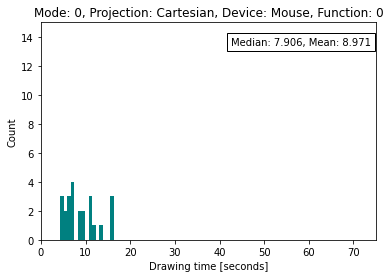

Mean:  8.9711285929375
Median:  7.90646904725


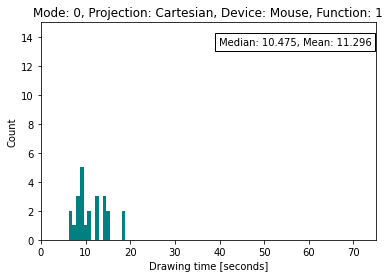

Mean:  11.295870671875
Median:  10.47534650575


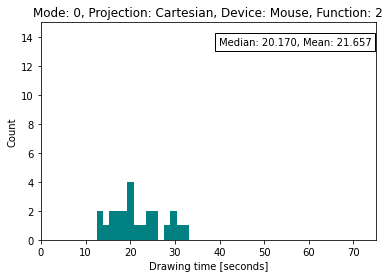

Mean:  21.656810596875
Median:  20.170229374999998


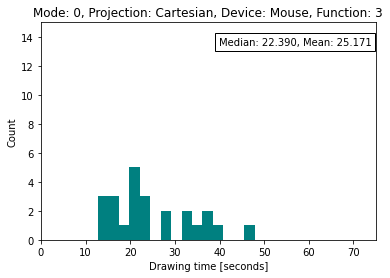

Mean:  25.17108643083333
Median:  22.390232685


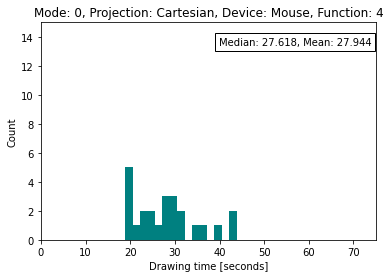

Mean:  27.944152956249997
Median:  27.617840407499997


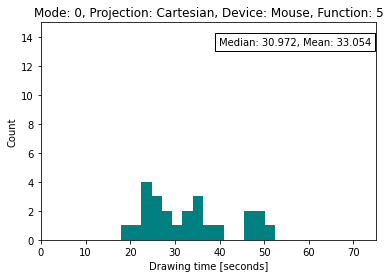

Mean:  33.05432457229167
Median:  30.9719857575


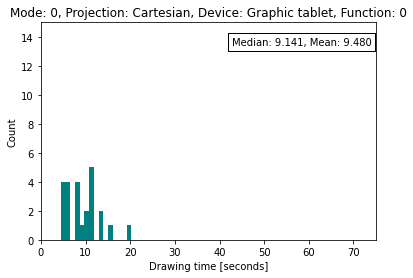

Mean:  9.480288733541666
Median:  9.141077221


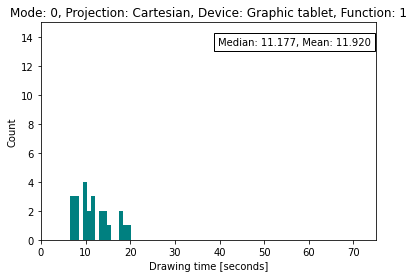

Mean:  11.920463547166667
Median:  11.17651873825


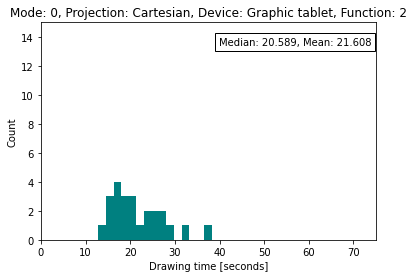

Mean:  21.60761583375
Median:  20.589443565


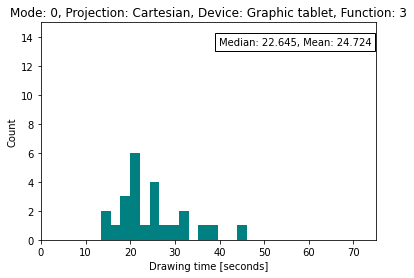

Mean:  24.724190413541667
Median:  22.644792975


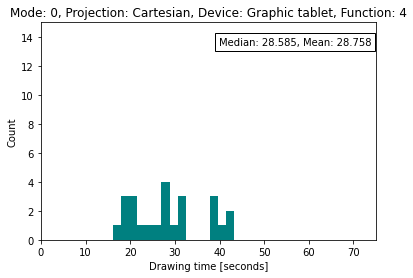

Mean:  28.757676910208335
Median:  28.5851203225


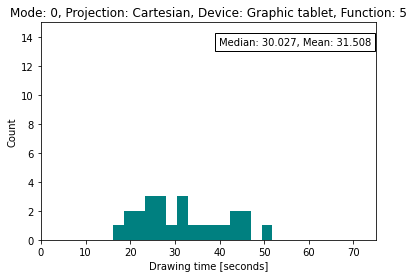

Mean:  31.508097807291666
Median:  30.026735485000003


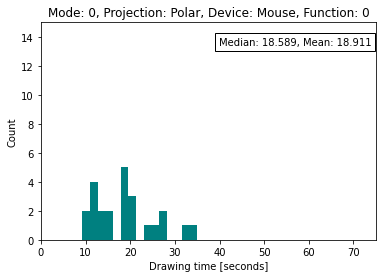

Mean:  18.910516470625
Median:  18.5890997075


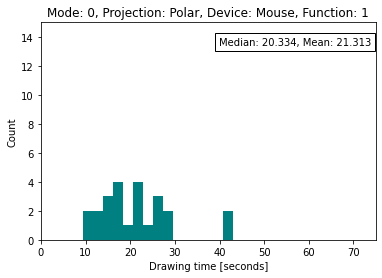

Mean:  21.313061878895834
Median:  20.33363271


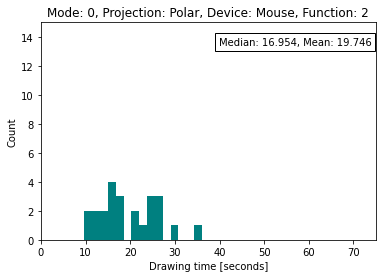

Mean:  19.746401225666666
Median:  16.953786372499998


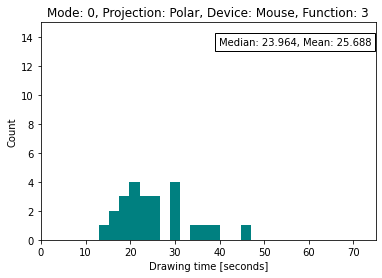

Mean:  25.68756569395833
Median:  23.9640946375


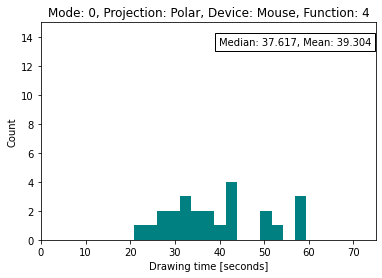

Mean:  39.30449399374999
Median:  37.616853177500005


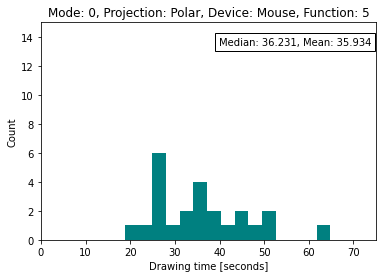

Mean:  35.93439653
Median:  36.2310737975


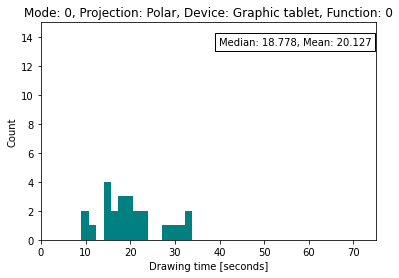

Mean:  20.1271989895625
Median:  18.778102875000002


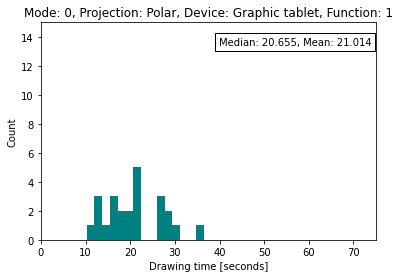

Mean:  21.0144107594375
Median:  20.6549972325


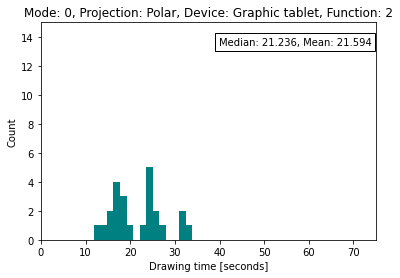

Mean:  21.594449624166668
Median:  21.2359825375


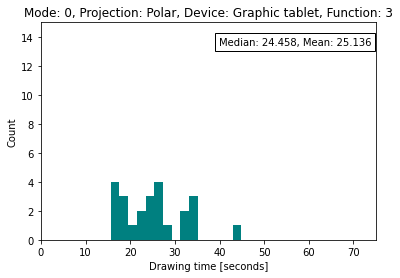

Mean:  25.135678852708327
Median:  24.45807314


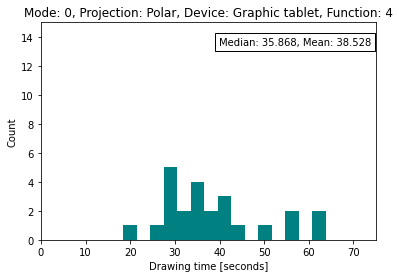

Mean:  38.52831572333333
Median:  35.867712260000005


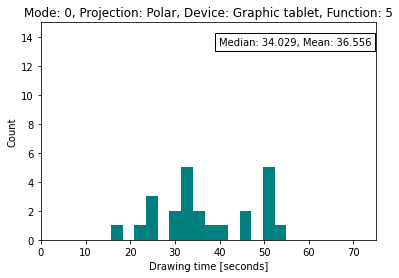

Mean:  36.556435996875
Median:  34.0293551675


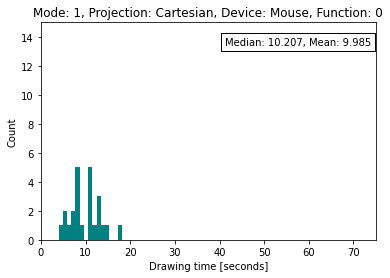

Mean:  9.985332459
Median:  10.207162738000001


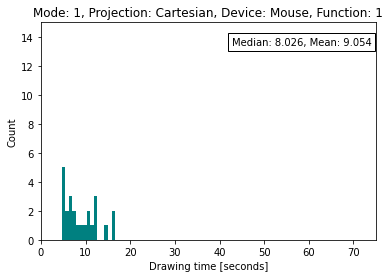

Mean:  9.053879866791666
Median:  8.0264214875


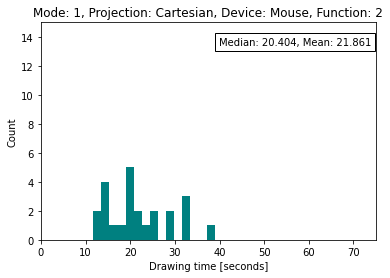

Mean:  21.860873117708334
Median:  20.404358505


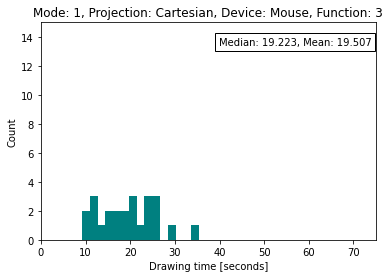

Mean:  19.506553783958335
Median:  19.2229008675


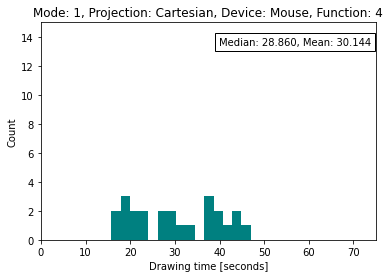

Mean:  30.144331047499993
Median:  28.859760639999998


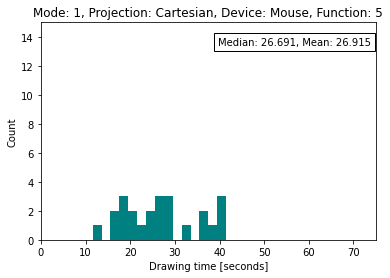

Mean:  26.915239766666662
Median:  26.6905197525


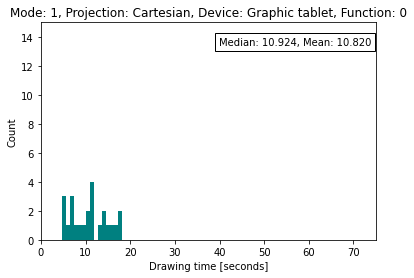

Mean:  10.819806168416667
Median:  10.924229085


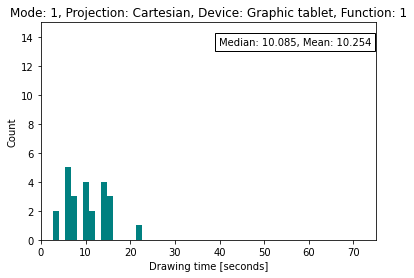

Mean:  10.254482805916666
Median:  10.08490479175


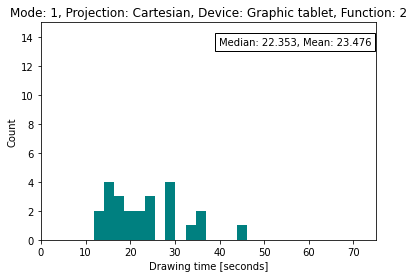

Mean:  23.475666974791665
Median:  22.3530209625


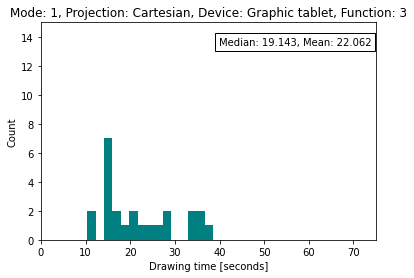

Mean:  22.062356381895835
Median:  19.142650845000002


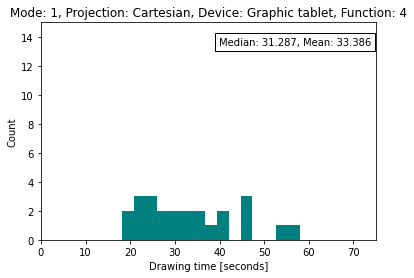

Mean:  33.386455068958334
Median:  31.287252785


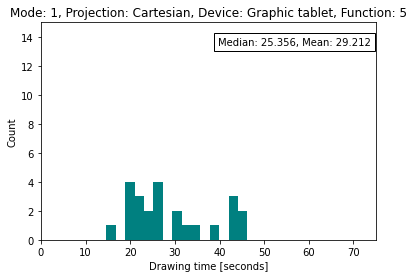

Mean:  29.21155466104167
Median:  25.356193304999998


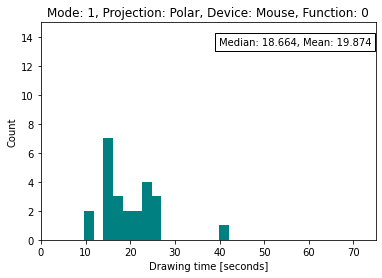

Mean:  19.8737872934375
Median:  18.664352895


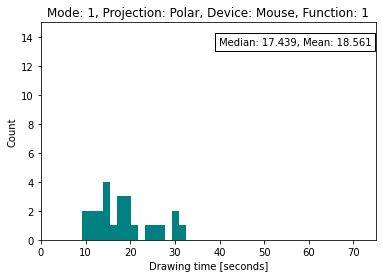

Mean:  18.561386594791667
Median:  17.43926585


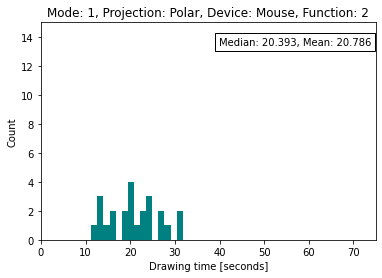

Mean:  20.785790249479167
Median:  20.39291543


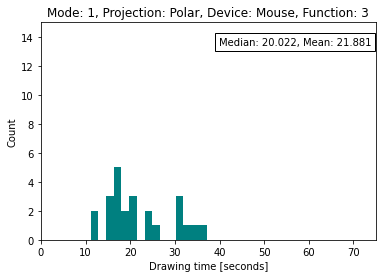

Mean:  21.88144977
Median:  20.0218842025


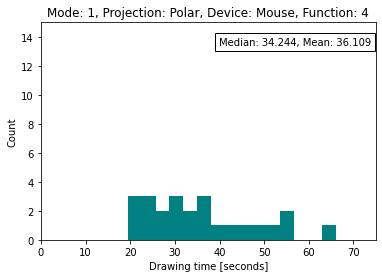

Mean:  36.10873563104167
Median:  34.2440846575


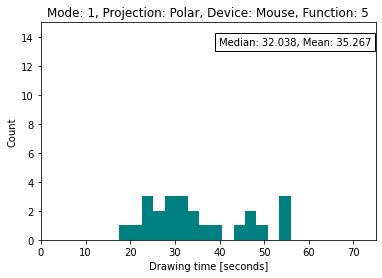

Mean:  35.26743182020834
Median:  32.0377859475


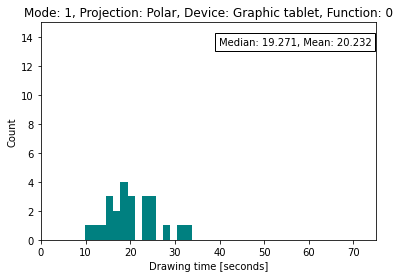

Mean:  20.231552327895834
Median:  19.270808935


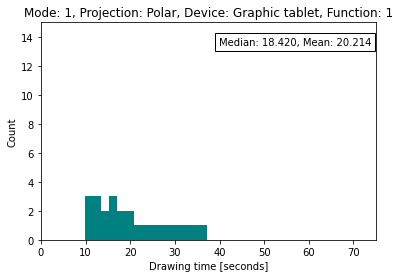

Mean:  20.213697632145834
Median:  18.41965139


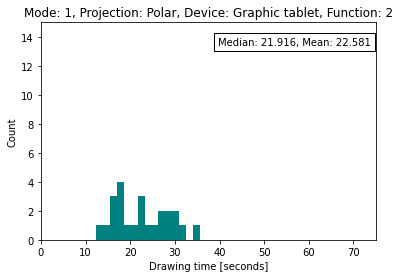

Mean:  22.580721259166666
Median:  21.9161176075


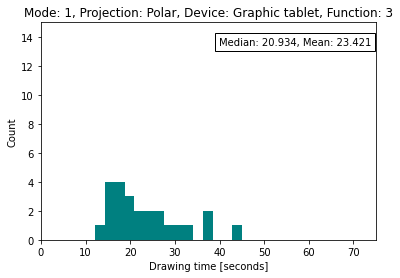

Mean:  23.420964877083332
Median:  20.93408823


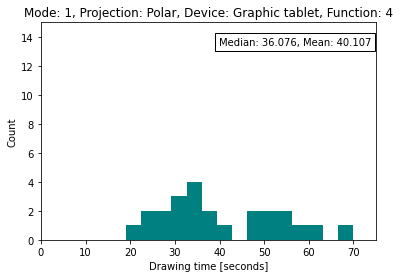

Mean:  40.107453908125
Median:  36.075751185


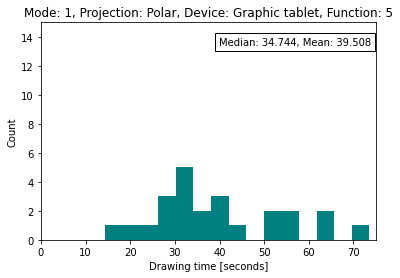

Mean:  39.50805553270833
Median:  34.7443329675


In [22]:
def getAllDrawingTimesForFunc(projection, funcId, device, experimentMode, data=df):
    # filter out by projection, Cartesian or Polar
    drawingTimes = data[data['Function projection'] == projection]
    # filter out by function ID
    drawingTimes = drawingTimes[drawingTimes['Function ID'] == funcId]
    # filter out by test (experiment mode)
    drawingTimes = drawingTimes[drawingTimes['Test mode'] == experimentMode]
    # filter out by device
    drawingTimes = drawingTimes[drawingTimes['Device'] == device]
    
    # for each user, find his/her average for this function
    participants = list(set(drawingTimes["Participant name"]))
    # find average of each participant for this function
    retval = []
    for participant in participants:
        dataForParticipant = drawingTimes[drawingTimes["Participant name"] == participant]
        avg = np.mean(dataForParticipant["Drawing time"].values)
        retval.append(avg)
    
    drawingTimes = drawingTimes['Drawing time'].values
    
    # return this to return ALL drawing times, without calculating mean for each participant
    # return drawingTimes
    return retval

projection = "Polar"
funcId = 0
device = "Mouse"
experimentMode = 0

for experimentMode in TEST_MODES:
    for projection in PROJECTIONS:
        for device in DEVICES:
            for funcId in FUNC_IDS:
                dts = getAllDrawingTimesForFunc(projection, funcId, device, experimentMode)

                plt.figure()
                plt.hist(dts, color="teal", bins=15)
                # limits are hard-coded, if I ever have time, I will make the limits calculation smarter
                xlim = [0, 15]
                ylim = [0, 75]
                plt.ylim(xlim)
                plt.xlim(ylim)
                
                # add text with Median an Mean displayed
                text = "Median: %.3f, Mean: %.3f" % (np.median(dts), np.mean(dts))
                plt.text(ylim[1]-1, xlim[1]-1, text, ha='right', va='top', bbox=dict(facecolor='white', alpha=1))
                
                plt.title(
                    "Mode: %s, Projection: %s, Device: %s, Function: %s"
                     % (experimentMode, projection, device, funcId)
                )
                plt.ylabel("Count")
                plt.xlabel("Drawing time [seconds]")
                saveFigure(
                    drawingTimeHistogramsFolderPath \
                    + "mode-" + str(experimentMode) \
                    + "_device-" + device + \
                    "_function-" + str(funcId) +".png"
                )
                plt.show()
                print("Mean: ", np.mean(dts))
                print("Median: ", np.median(dts))



# Average drawing time for each curve on each input device

In [23]:
def getAvgForFunc(projection, funcId, device, experimentMode = 0, data=df):
    drawingTimes = getAllDrawingTimesForFunc(projection, funcId, device, experimentMode, data)
    
    avg = np.mean(drawingTimes) if centralTendency=='mean' else np.median(drawingTimes)
    
    return avg

def getAvgsByFilter(projections, funcIds, devices, experimentModes, iodName=iodModelName, data=df):
    times = []
    iods = []
    for experimentMode in experimentModes:
        for device in devices:
            for projection in projections:
                for funcId in funcIds:
                    avg = getAvgForFunc(projection, funcId, device, experimentMode, data=data)
                    times.append(avg)
                    iods.append(getIodForFunc(projection, experimentMode, funcId, iodName))
                    # use this if you want to get ALL drawing times paired with iods
                    # avg = getAllDrawingTimesForFunc(projection, funcId, device, experimentMode, data)
                    # times.extend(avg)
                    # iods.extend([getIodForFunc(projection, experimentMode, funcId)] * len(avg))
                    
    return times, iods

MAX_AVG_DRAW_TIME = round(max(getAvgsByFilter(PROJECTIONS, FUNC_IDS, DEVICES, TEST_MODES, "kappa")[0]))
MAX_AVG_DRAW_TIME += 0.2 * MAX_AVG_DRAW_TIME

# for mode in TEST_MODES:
#    print("----------------- MODE:", mode)
#    for device in DEVICES:
#        print(":::", device, ":::")
#        for funcId in FUNC_IDS:
#            print("--> Function: ", funcId)
#            for projection in PROJECTIONS:
#                avg = getAvgForFunc(projection, funcId, device, mode)
#                print("\t", projection, ": ", avg)


# Test plots

In [24]:
def plotForExperiment(experimentModes, projections = PROJECTIONS):
    for experimentMode in experimentModes:
        for device in DEVICES:
            plt.figure()
            for projection in projections: 
                times = []
                for funcId in funcIds:
                    times.append(getAvgForFunc(projection, funcId, device, experimentMode))

                iods = (getIodsAsArray([projection], [experimentMode]))
                plt.scatter(iods, times, label=projection)


            plt.ylabel("Drawing time (s)")
            plt.xlabel("Index of difficulty")
            plt.ylim([0, MAX_AVG_DRAW_TIME])
            plt.xlim([0, getMaxIodForPlot()])
            plt.legend(loc='upper left')
            plt.title("Experiment %d, %s, %s" %(experimentMode, device, projections) )
            
            plt.show()

## Test plots

In [25]:
# plotForExperiment([0, 1])

# Linear regression

In [26]:
def calculateResiduals(model, x, y):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(x)
    residuals = abs(y) - abs(predictions)
    return residuals, predictions


def checkLinearAssumption(model, x, y, axes):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable. If not, either a quadratic term or another
               algorithm should be used.
    """
    print('Assumption 1: Linear Relationship between the Target and the Feature', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    residuals, predictions = calculateResiduals(model, x, y)
    
    # Plotting the actual vs predicted values
    axes.scatter(x=y, y=predictions, color="coral", edgecolors="grey")
    axes.axis("equal")
    axes.set_title("Actual vs Predicted")
    axes.set_xlabel("Actual")
    axes.set_ylabel("Predicted")
    axes.grid(True)
        
    # Plotting the diagonal line
    lineCoords = np.arange(np.min(predictions), np.max(predictions))
    axes.plot(lineCoords, lineCoords, color="black")
    return axes

def normalErrorsAssumption(model, x, y, axes, p_value_thresh=0.05):
    """
    Normality: Assumes that the error terms are normally distributed. If they are not,
    nonlinear transformations of variables may solve this.
               
    This assumption being violated primarily causes issues with the confidence intervals
    """
    print('Assumption 2: The error terms are normally distributed', '\n')
    
    # Calculating residuals for the Anderson-Darling test
    residuals, predictions = calculateResiduals(model, x, y)
    
    print('Using the Anderson-Darling test for normal distribution')

    # Performing the test on the residuals
    p_value = normal_ad(residuals)[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    axes.set_title('Distribution of Residuals')
    sns.histplot(residuals, ax=axes)
    
    print()
    if p_value > p_value_thresh:
        print('Assumption satisfied')
    else:
        print('Assumption not satisfied')
        print()
        print('Confidence intervals will likely be affected')
        print('Try performing nonlinear transformations on variables')

        
def multicollinearityAssumption(model, x, y, axes, feature_names=None):
    """
    Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                       correlation among the predictors, then either remove prepdictors with high
                       Variance Inflation Factor (VIF) values or perform dimensionality reduction
                           
                       This assumption being violated causes issues with interpretability of the 
                       coefficients and the standard errors of the coefficients.
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    print('Assumption 3: Little to no multicollinearity among predictors')
        
    # Plotting the heatmap
    sns.heatmap(pd.DataFrame(x, columns=feature_names).corr(), annot=True, ax=axes)
    axes.set_title('Correlation of Variables')
        
    print('Variance Inflation Factors (VIF)')
    print('> 10: An indication that multicollinearity may be present')
    print('> 100: Certain multicollinearity among the variables')
    print('-------------------------------------')
       
    # Gathering the VIF for each variable
    VIF = [variance_inflation_factor(features, i) for i in range(x.shape[1])]
    for idx, vif in enumerate(VIF):
        print('{0}: {1}'.format(feature_names[idx], vif))
        
    # Gathering and printing total cases of possible or definite multicollinearity
    possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
    definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
    print()
    print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
    print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
    print()

    if definite_multicollinearity == 0:
        if possible_multicollinearity == 0:
            print('Assumption satisfied')
        else:
            print('Assumption possibly satisfied')
            print()
            print('Coefficient interpretability may be problematic')
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')

    else:
        print('Assumption not satisfied')
        print()
        print('Coefficient interpretability will be problematic')
        print('Consider removing variables with a high Variance Inflation Factor (VIF)')

        
def autocorrelationAssumption(model, x, y):
    """
    Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                     autocorrelation, then there is a pattern that is not explained due to
                     the current value being dependent on the previous value.
                     This may be resolved by adding a lag variable of either the dependent
                     variable or some of the predictors.
    """
    from statsmodels.stats.stattools import durbin_watson
    print('Assumption 4: No Autocorrelation', '\n')
    
    # Calculating residuals for the Durbin Watson-tests
    residuals, predictions = calculateResiduals(model, x, y)

    print('\nPerforming Durbin-Watson Test')
    print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
    print('0 to 2< is positive autocorrelation')
    print('>2 to 4 is negative autocorrelation')
    print('-------------------------------------')
    durbinWatson = durbin_watson(residuals)
    print('Durbin-Watson:', durbinWatson)
    if durbinWatson < 1.5:
        print('Signs of positive autocorrelation', '\n')
        print('Assumption not satisfied')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation', '\n')
        print('Assumption not satisfied')
    else:
        print('Little to no autocorrelation', '\n')
        print('Assumption satisfied')

def homoscedasticityAssumption(model, x, y, axes):
    """
    Homoscedasticity: Assumes that the errors exhibit constant variance
    """
    print('Assumption 5: Homoscedasticity of Error Terms', '\n')
    
    print('Residuals should have relative constant variance')
        
    # Calculating residuals for the plot
    residuals, predictions = calculateResiduals(model, x, y)

    # Plotting the residuals
    indices = np.arange(0, len(residuals))
    axes.scatter(x=indices, y=residuals, alpha=0.5)
    axes.plot(np.repeat(0, np.max(indices) + 1), color='darkorange', linestyle='--')
    axes.set_title('Residuals')

    
def testRegressionAssumptions(reg, x, y, title):
    figure, axes = plt.subplots(1, 3)
    figure.set_size_inches(15, 5)
    checkLinearAssumption(reg, x, y, axes[0])
    normalErrorsAssumption(reg, x, y, axes[1])
    # multicollinearityAssumption(reg, x, y, axes[1, 0])
    autocorrelationAssumption(reg, x, y)
    homoscedasticityAssumption(reg, x, y, axes[2])
    
    st = figure.suptitle(title)
    figure.tight_layout(pad=2)
    # shift subplots down:
    st.set_y(1)
    figure.subplots_adjust(top=0.85)
    
    saveFigure(linearRegressionsFolderPath + "_assumptions_" + title.replace(' ', '_').replace('\n', ''))
    plt.close(figure)


def getBasePlotTitle(projections, device, experimentModes):
    return "Linear regression for %s, %s, mode=%s,\nCentral Tendency=%s,Index Of Difficulty=%s" \
                   %(projections, device, experimentModes, centralTendency, iodModelName)

def getRegressionCoefficients(reg):
    x1 = 0
    x2 = 1
    y1, y2 = reg.predict(np.array([[x1], [x2]]))
    # Coefficients: y = ax + b
    b = y1
    a = (y2 - y1) / (x2 - x1)
    return a, b

# get x and y data for linear regression
def getDataForRegression(projections, experimentModes, device):
    y, iods = np.array(getAvgsByFilter(projections, FUNC_IDS, [device], experimentModes))
    x = [[iod] for iod in iods]
    return x, y

def getFormattedRegressionMetrics(reg, x, y):
    a, b = getRegressionCoefficients(reg)
    y_predicted = reg.predict(x)
    mse = metrics.mean_squared_error(y_predicted, y)
    rmspe = (np.sqrt(np.mean(np.square((y_predicted - y) / y_predicted)))) * 100
    print(rmspe)
    return 'y = %.3fx + %.3f\nR^2 = %.3f\nRMSE = %.3f\nRMSPE = %.3f%%' % (a, b, reg.score(x, y), np.sqrt(mse), rmspe)

# model metrics :: for evaulating the regression model
def printRegressionModelMetrics(reg, x, y):
    print(getFormattedRegressionMetrics(reg, x, y))

# training and retrieving the model 
def getRegressionModel(projections, experimentModes, device, axes):
    x, y = getDataForRegression(projections, experimentModes, device)
    reg = LinearRegression().fit(x, y)
    title = getBasePlotTitle(projections, device, experimentModes)
    plotDataAndReg(reg, x, y, title, axes)
    printRegressionModelMetrics(reg, x, y)
    testRegressionAssumptions(reg, x, y, title)

    return reg

def plotDataAndReg(reg, x, y, title, axes):
    axes.scatter(x, y, label="Experiment data", color="lightsteelblue", edgecolors="black")
    MAX_IOD = getMaxIodForPlot()

    predictX = np.linspace(1, MAX_IOD, 10)
    predictY = reg.predict([[x] for x in predictX])
    axes.plot(predictX, predictY, color="black", label="Linear regression")
    
    axes.set_ylabel("Drawing time (seconds)")
    axes.set_xlabel("Index of difficulty")
    axes.set_ylim([0, MAX_AVG_DRAW_TIME])
    axes.set_xlim([0, MAX_IOD])
    axes.grid(True)
    axes.legend(loc='upper left')
    axes.set_title(title)
    # axes.axis('scaled')
    
    axes.text(0, MAX_AVG_DRAW_TIME - 6,
             getFormattedRegressionMetrics(reg, x, y),
             ha='left', va='top',
             bbox=dict(facecolor='white', alpha=1)
    )
    

def validateRegressionModel(reg, projections, experimentModes, device, axes):  
    x, y = getDataForRegression(projections, experimentModes, device)
    title = getBasePlotTitle(projections, device, experimentModes) + " VALIDATED"
    
    testRegressionAssumptions(reg, x, y, title)
    plotDataAndReg(reg, x, y, title, axes)
    printRegressionModelMetrics(reg, x, y)
    
    
def trainRegressionModelThenValidate(projections, device):
    print("\n\nSKLEARN")
    MAX_IOD = getMaxIodForPlot()
    dim = max(MAX_IOD / 8, MAX_AVG_DRAW_TIME / 4)
    (width, height) = dim, dim
    figure, axes = plt.subplots(2)
    figure.set_size_inches(width, height)
    
    reg = getRegressionModel(projections, [0], device, axes[0])
    validateRegressionModel(reg, projections, [1], device, axes[1])

    figure.tight_layout(pad=3)
    title = getBasePlotTitle(projections, device, TEST_MODES) + " BOTH"
    saveFigure(linearRegressionsFolderPath + title.replace(' ', '_').replace('\n', ''))
    
    plt.show(figure)
    
    # print("\n\nSTATSMODELS")
    # x, y = getDataForRegression(projections, [0], device)
    # constx = sm.add_constant(x)
    # reg = sm.OLS(y, constx).fit()
    # print(reg.summary())
    



SKLEARN
7.969980633120495
7.969980633120495
y = 1.968x + -72.246
R^2 = 0.944
RMSE = 2.042
RMSPE = 7.970%
Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.
Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.90155776389366
Residuals are normally distributed

Assumption satisfied
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 2.6424642436995494
Signs of negative autocorrelation 

Assumption not satisfied
Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance
Assumption 1: Linear 

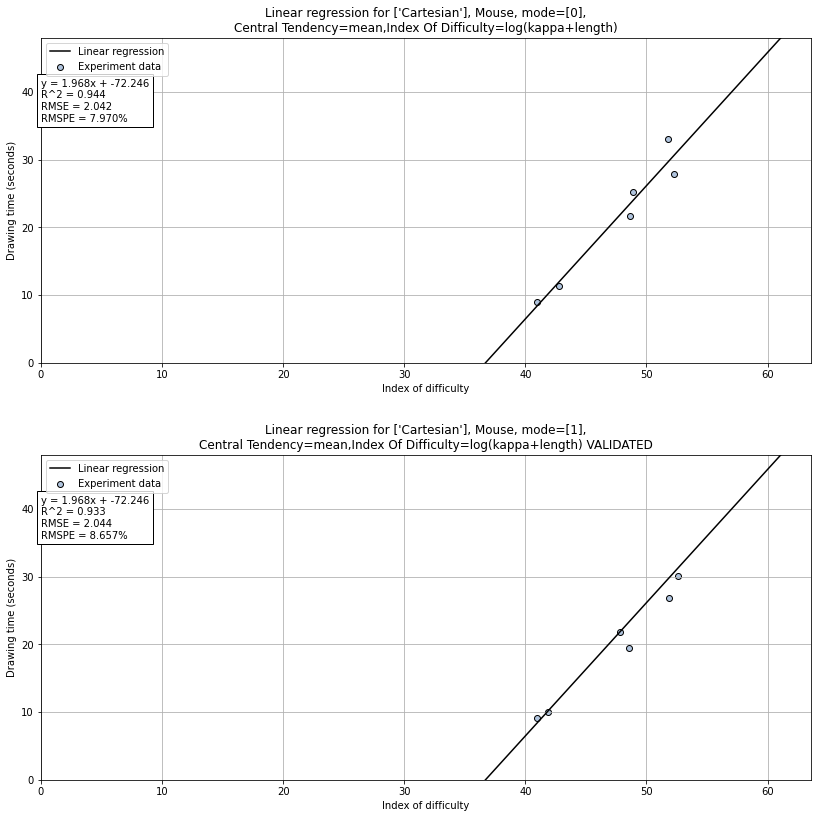



SKLEARN
5.863782496190292
5.863782496190292
y = 1.880x + -68.079
R^2 = 0.970
RMSE = 1.410
RMSPE = 5.864%
Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.
Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.8078428985161139
Residuals are normally distributed

Assumption satisfied
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 2.5113722461536274
Signs of negative autocorrelation 

Assumption not satisfied
Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance
Assumption 1: Linea

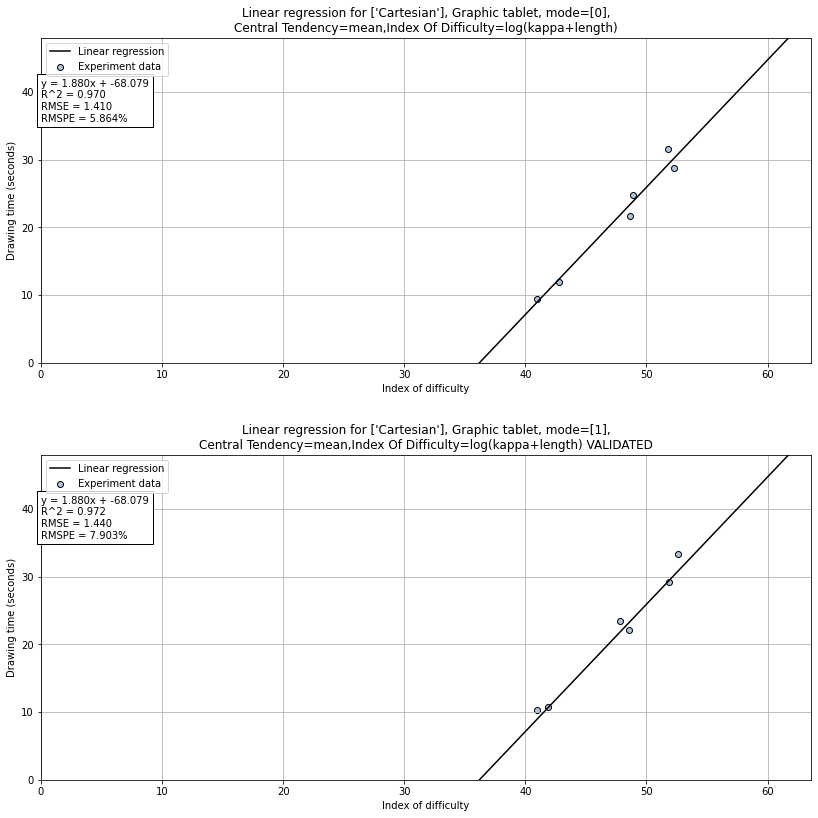



SKLEARN
6.063002566646421
6.063002566646421
y = 2.970x + -120.871
R^2 = 0.967
RMSE = 1.448
RMSPE = 6.063%
Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.
Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.3238191894256382
Residuals are normally distributed

Assumption satisfied
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 2.5211302690377004
Signs of negative autocorrelation 

Assumption not satisfied
Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance
Assumption 1: Line

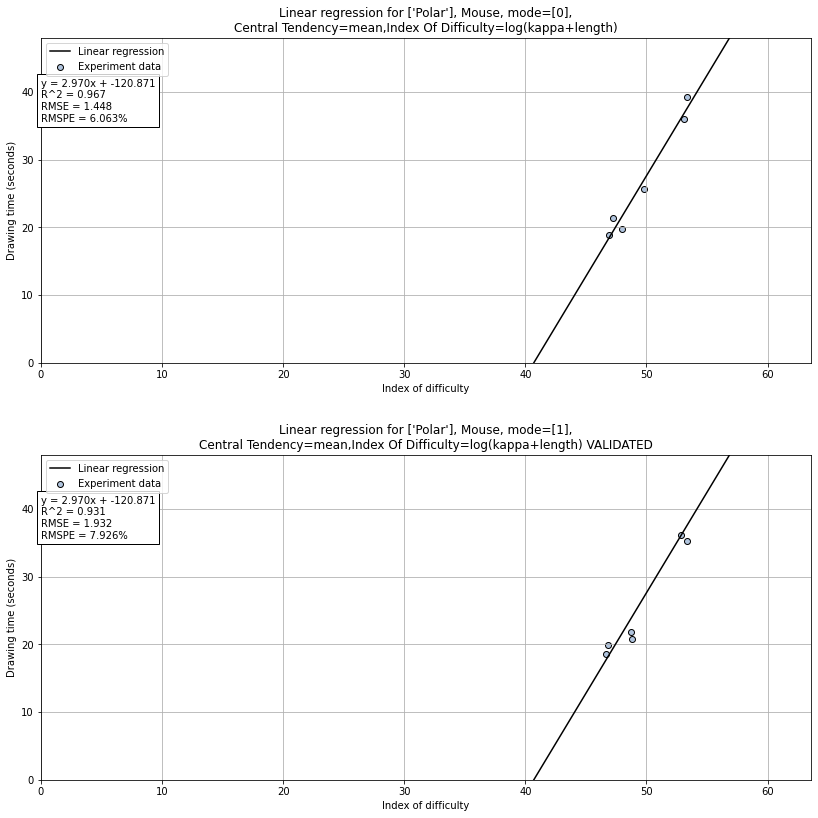



SKLEARN
4.464749524250671
4.464749524250671
y = 2.811x + -112.630
R^2 = 0.977
RMSE = 1.143
RMSPE = 4.465%
Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.
Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.360468306333722
Residuals are normally distributed

Assumption satisfied
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 2.1432576873535845
Little to no autocorrelation 

Assumption satisfied
Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance
Assumption 1: Linear Relatio

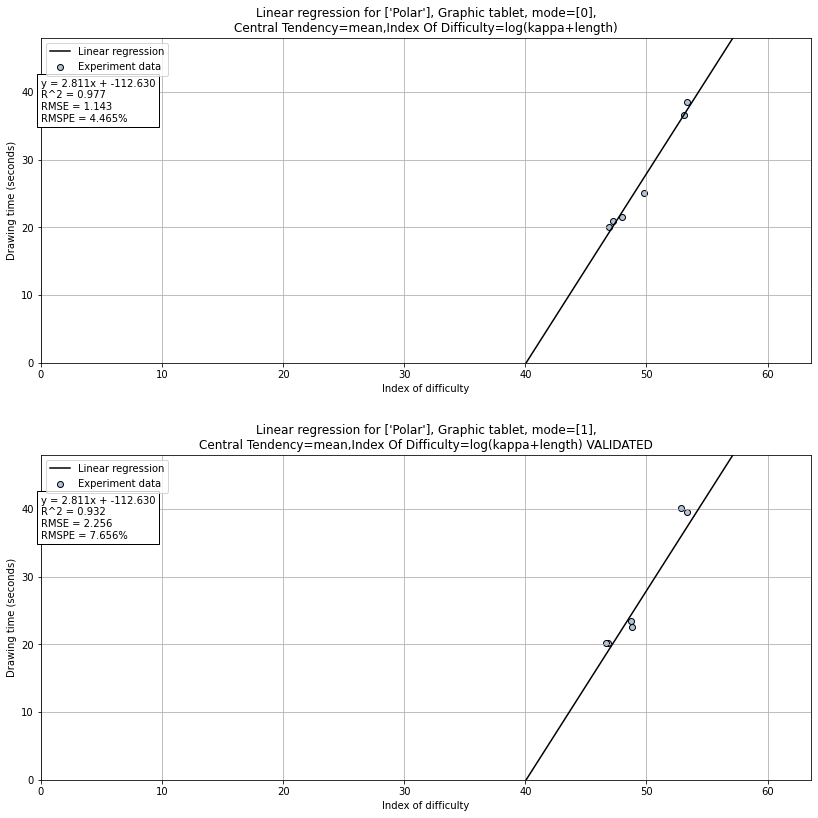



SKLEARN
12.80788965510656
12.80788965510656
y = 2.269x + -86.279
R^2 = 0.925
RMSE = 2.398
RMSPE = 12.808%
Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.
Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.9097584650742803
Residuals are normally distributed

Assumption satisfied
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 2.1700912137247097
Little to no autocorrelation 

Assumption satisfied
Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance
Assumption 1: Linear Relati

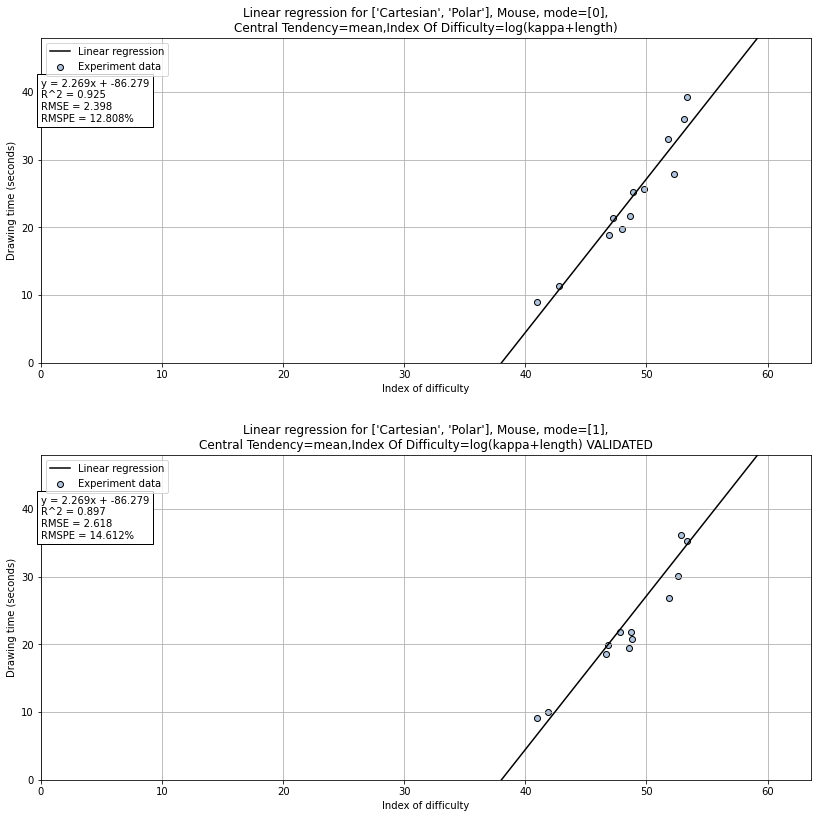



SKLEARN
10.158275269745747
10.158275269745747
y = 2.185x + -82.015
R^2 = 0.941
RMSE = 2.040
RMSPE = 10.158%
Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.
Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.885371774860153
Residuals are normally distributed

Assumption satisfied
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.6224676063257393
Little to no autocorrelation 

Assumption satisfied
Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance
Assumption 1: Linear Relat

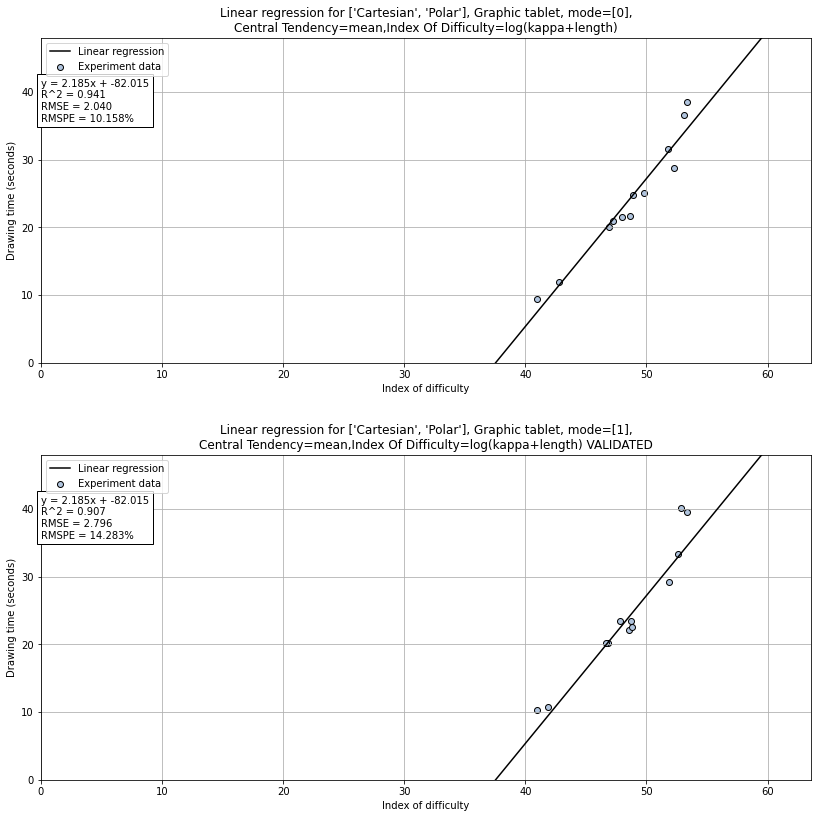

In [27]:
for projections in [["Cartesian"], ["Polar"], PROJECTIONS]:
    for device in DEVICES:
        trainRegressionModelThenValidate(projections, device)
        
        
        #reg2 = getRegressionModel(projections, [0, 1], device)
        # test the residuals as shown here: https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/

# Participant data

Number of participants: 24
Average participant age: 23.542
Standard deviation: 1.154

 ::::
Number of Left-handed participants: 3
Percentage of Left-handed participants 12.5 %
Number of Right-handed participants: 21
Percentage of Right-handed participants 87.5 %
Number of Ambidextrous participants: 0
Percentage of Ambidextrous participants 0.0 %

 ::::
Number of expert graphic tablet participants: 1
Percentage of expert graphic tablet participants 4.2 %
Number of expert mouse participants: 24
Percentage of expert graphic tablet participants 100.0 %

 ::::
Average drawing times
Participant;Device;Projections;Drawing Time Mean;Drawing time stdev
Marin_Vidakovic_Lipovac;Mouse;['Cartesian'];15.358;5.2655
Mateja Napravnik;Mouse;['Cartesian'];19.5263;9.6693
SadilaJeMare;Mouse;['Cartesian'];18.0791;9.625
Shanko;Mouse;['Cartesian'];29.4701;12.459
Vrtni_Patuljak;Mouse;['Cartesian'];18.2788;9.9836
Zmaj Zemun;Mouse;['Cartesian'];20.3741;8.5857
aronta;Mouse;['Cartesian'];14.4917;6.7344
asubasic;Mo

kskunca;Graphic tablet;['Cartesian', 'Polar'];33.4248;14.1756
lotovic;Graphic tablet;['Cartesian', 'Polar'];24.7792;8.1761
mdudic;Graphic tablet;['Cartesian', 'Polar'];32.6685;12.6527
mduvnjak;Graphic tablet;['Cartesian', 'Polar'];35.9414;14.5384
mnjiric;Graphic tablet;['Cartesian', 'Polar'];20.1213;8.3579
mrGauss;Graphic tablet;['Cartesian', 'Polar'];31.8839;15.1122
mtvrdinic;Graphic tablet;['Cartesian', 'Polar'];18.9254;5.3081
rpolic;Graphic tablet;['Cartesian', 'Polar'];25.0632;10.5331
ssimunic;Graphic tablet;['Cartesian', 'Polar'];14.005;6.2594
wdragon;Graphic tablet;['Cartesian', 'Polar'];18.9729;7.8506
p-value from the test - below 0.05 generally means non-normal: 0.16563005609138212
Data is normally distributed





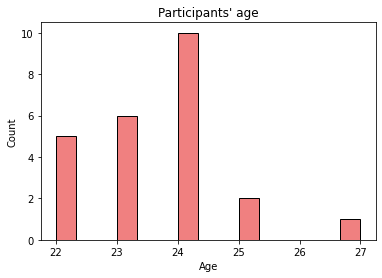

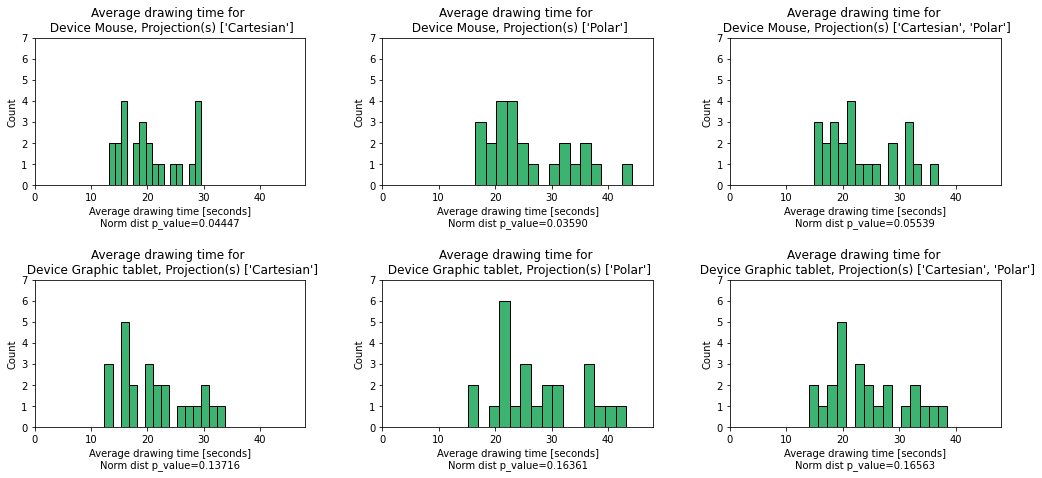

In [28]:
participants = list(set(test0data['Participant name']))

print("Number of participants:", len(participants))

ages = []
handednessFreq = {
    "Left-handed": 0,
    "Right-handed": 0,
    "Ambidextrous": 0
}
hasExpWTablet = 0
hasExpWMouse = 0
for participant in participants:
    row = df[df['Participant name'] == participant]
    age = row['Participant age'].values[0]
    handednessFreq[row['Participant handedness'].values[0]] += 1
    hasExpWTablet += row['Expert Graphic Tablet User'].values[0]
    hasExpWMouse += row['Expert Mouse User'].values[0]
    # print(participant, age)
    ages.append(age)

plt.figure()
plt.hist(ages, color="lightcoral", bins=15, edgecolor="black")
plt.ylabel("Count")
plt.xlabel("Age")
plt.title("Participants' age")
saveFigure(participantDataFolderPath + "participant_age")
plt.plot
print("Average participant age:", round(np.mean(ages), 3))
print("Standard deviation:", round(np.std(ages), 3))

print("\n ::::")

for handedness in handednessFreq:
    freq = handednessFreq[handedness]
    print("Number of " + handedness + " participants:", freq)
    print("Percentage of " + handedness + " participants", round(freq * 1.0 / len(participants), 3)*100, '%')

print("\n ::::")
print("Number of expert graphic tablet participants:", hasExpWTablet)
print("Percentage of expert graphic tablet participants",
      round(hasExpWTablet * 1.0 / len(participants), 3)*100, '%'
)

print("Number of expert mouse participants:", hasExpWMouse)
print("Percentage of expert graphic tablet participants",
      round(hasExpWMouse * 1.0 / len(participants), 3)*100, '%'
)

print("\n ::::")
print("Average drawing times")

# Anderson-Darling test for normal distribution unknown mean and variance.
def isDataNormallyDistributed(data, p_value_thresh=0.05):
    p_value = normal_ad(data)[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Data is not normally distributed')
    else:
        print('Data is normally distributed')
    return p_value


# separator is semicolon because the 'projections' column has commas in it
separator = ';'

# Average drawing time per user
sortedParticipants = sorted(participants)
figure, axes = plt.subplots(len(DEVICES), len([["Cartesian"], ["Polar"], PROJECTIONS]))
figure.set_size_inches(15, 7)

for k, device in enumerate(DEVICES):
    for j, projections in enumerate([["Cartesian"], ["Polar"], PROJECTIONS]):
        pltData = []
        print("Participant","Device", "Projections","Drawing Time Mean", "Drawing time stdev", sep=separator)
        for i in range(len(sortedParticipants)):
            participant = sortedParticipants[i]
            dts = []
            for funcId in FUNC_IDS:
                for experimentMode in TEST_MODES:
                    drawingTimes = df[df['Participant name'] == participant]
                    drawingTimes, _ = getAvgsByFilter(projections, [funcId], [device], [experimentMode], data=drawingTimes)
                    dts.append(drawingTimes)
            print(participant, device, projections, round(np.mean(dts), 4), round(np.std(dts), 4), sep=separator)
            pltData.append(np.mean(dts))
        # print()
        ax = axes[k][j]
        ax.hist(pltData, color='mediumseagreen', bins=15, edgecolor="black")

        pValueNormDist = isDataNormallyDistributed(np.array(pltData))
        
        title = "Average drawing time for \n Device %s, Projection(s) %s" %(device, projections)
        ax.set_title(title)
        ax.set_ylabel("Count")
        ax.set_xlabel("Average drawing time [seconds]\nNorm dist p_value=%.5f" % (pValueNormDist))
        
        # this lim is hard-coded. if I ever have time, I should make this soft-coded :)
        ax.set_ylim([0, 7])
        ax.set_xlim([0, MAX_AVG_DRAW_TIME])
        print("\n\n")

figure.tight_layout(pad=2)
saveFigure(participantDataFolderPath + "Average_drawing_times")
plt.show()
            


## Error approximation

In [29]:
sortedParticipants = sorted(participants)

print("Participant index", "Mouse error mean", "Mouse error stdev", "Graphic tablet error mean", "Graphic tablet error stdev", sep=separator)
avgs = { "Mouse":[], "Graphic tablet":[]}
for i in range(len(sortedParticipants)):
    participant = sortedParticipants[i]
    print(participant, end='')
    for device in DEVICES:
        # epm = error per move
        epms = []
        for experimentMode in TEST_MODES:
            filename = "../Results_backup%s/%s/%s" %(experimentMode, participant, device)
            files = os.listdir(filename)
            for file in files:
                funcId = int(file[3])
                projtmp = file[10]
                projection = "Cartesian"
                if(projtmp in ["2", "3"]):
                    projection = "Polar"
                # filter out by projection, Cartesian or Polar
                errors = df[df['Function projection'] == projection]
                # filter out by function ID
                errors = errors[errors['Function ID'] == funcId]
                # filter out by test (experiment mode)
                errors = errors[errors['Test mode'] == experimentMode]
                errors = errors[errors['Participant name'] == participant]
                # filter out by device
                errors = errors[errors['Device'] == device]
                f = open(filename + "/" + file)
                
                errorVal = np.mean(errors["Error approx"].values) * 1.0 / len(f.readlines())
                epms.append(errorVal)
                f.close()
                # print(participant, projection, "(%s)" %projtmp, experimentMode, funcId, device, errorVal)
        print('', round(np.mean(epms), 6), round(np.std(epms), 6), sep=separator, end='')
        avgs[device].append(np.mean(epms))
    print()

Participant index;Mouse error mean;Mouse error stdev;Graphic tablet error mean;Graphic tablet error stdev
Marin_Vidakovic_Lipovac;0.030788;0.011263;0.030708;0.012842
Mateja Napravnik;0.02598;0.008112;0.028455;0.008879
SadilaJeMare;0.027604;0.010104;0.036846;0.014934
Shanko;0.018446;0.005908;0.018798;0.006488
Vrtni_Patuljak;0.028721;0.010888;0.028007;0.010928
Zmaj Zemun;0.022296;0.007368;0.028141;0.011593
aronta;0.025591;0.011881;0.035557;0.016128
asubasic;0.022956;0.008043;0.025117;0.009229
azahtila;0.022429;0.008087;0.024291;0.009475
bado97;0.018823;0.006911;0.023162;0.007969
dgrdinic;0.026961;0.015374;0.036031;0.017865
dmakar;0.025251;0.009425;0.034391;0.015538
kfilipcic;0.02042;0.007781;0.022104;0.009983
kknezic;0.031666;0.010652;0.033651;0.011138
kskunca;0.020906;0.007445;0.023608;0.009039
lotovic;0.02588;0.00977;0.029385;0.009761
mdudic;0.01994;0.007049;0.020253;0.006187
mduvnjak;0.019522;0.007279;0.023437;0.008675
mnjiric;0.024718;0.008685;0.028142;0.010692
mrGauss;0.015222;0.004

p-value from the test - below 0.05 generally means non-normal: 0.907888576911617
Data is normally distributed
p-value from the test - below 0.05 generally means non-normal: 0.8390789423035425
Data is normally distributed


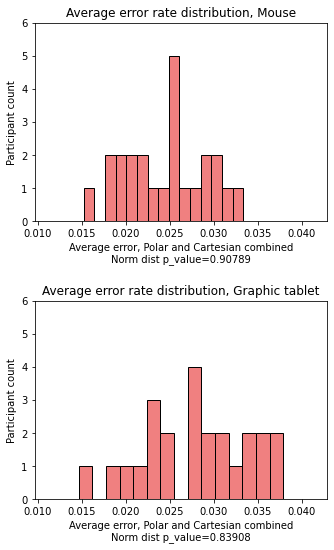

In [30]:
maxAvg = np.max([np.max(avgs["Mouse"]), np.max(avgs["Graphic tablet"])])
minAvg = np.min([np.min(avgs["Mouse"]), np.min(avgs["Graphic tablet"])])
xlim = [minAvg - 0.005, maxAvg + 0.005]
    
figure, (ax1, ax2) = plt.subplots(2)
figure.set_size_inches(5, 8)
ax1.hist(avgs["Mouse"], color="lightcoral", bins=15, edgecolor="black")

pValueNormDist = isDataNormallyDistributed(np.array(avgs["Mouse"]))

title = "Average error rate distribution, Mouse"
ax1.set_title(title)
ax1.set_xlabel("Average error, Polar and Cartesian combined\nNorm dist p_value=%.5f" % (pValueNormDist))
ax1.set_ylabel("Participant count")
ax1.set_ylim([0, 6])
ax1.set_xlim(xlim)

ax2.hist(avgs["Graphic tablet"], color="lightcoral", bins=15, edgecolor="black")

pValueNormDist = isDataNormallyDistributed(np.array(avgs["Graphic tablet"]))

title = "Average error rate distribution, Graphic tablet"
ax2.set_title(title)
ax2.set_xlabel("Average error, Polar and Cartesian combined\nNorm dist p_value=%.5f" % (pValueNormDist))
ax2.set_ylabel("Participant count")
ax2.set_ylim([0, 6])
ax2.set_xlim(xlim)

figure.tight_layout(pad=2)
saveFigure(participantDataFolderPath + "Error_rates_dist")
plt.show()